# 1 準備

In [1]:
!nvidia-smi

Wed Jun 15 11:29:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# データ作成に使用するライブラリ
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np

# 学習テクニックライブラリ
import torchsummary # モデルを確認するライブラリ
import pickle # モデルの保存と読み込みするライブラリ
import torchvision.utils as vutils # 画像データを保存するライブラリ
from torch.utils.data import Dataset # データセット作成に使用するライブラリ
from pathlib import Path # データセット作成に使用するライブラリ
from PIL import Image # データセット作成に使用するライブラリ

torch.manual_seed(1)

In [3]:
batch_size = 100
n_channel = 100
n_epoch = 10

In [4]:
!mkdir './data'
dataset = datasets.MNIST(root='.', download=True)

for idx, (img, _) in enumerate(dataset):
    img.save('./data/{:05d}.jpg'.format(idx))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
!find /content/data/* -type f | wc -l

60000


In [6]:
class Image_dataset(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_paths = self._get_img_paths(img_dir)
        self.transform = transform

    def __getitem__(self, index):
        path = self.img_paths[index]
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)

        return img

    def _get_img_paths(self, img_dir):
        img_dir = Path(img_dir)
        img_paths = [p for p in img_dir.iterdir() if p.suffix in [".jpg", ".jpeg", ".png", ".bmp"]]
        return img_paths

    def __len__(self):
        return len(self.img_paths)

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = Image_dataset("/content/data", transform)
dataloader = DataLoader(dataset, batch_size=100)

In [8]:
# データの読み込み
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# Google ドライブにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
%cd '/content/gdrive/MyDrive/'

/content/gdrive/MyDrive


In [11]:
!mkdir './result_image'
!mkdir './result_model'

# 2 モデル

In [12]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(n_channel, 512, 3, 1, 0),
                nn.BatchNorm2d(512),
                nn.ReLU()
            ), 
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(512, 256, 3, 2, 0),
                nn.BatchNorm2d(256),
                nn.ReLU()
            ),
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            'layer3': nn.Sequential(
                nn.ConvTranspose2d(128, 1, 4, 2, 1),
                nn.Tanh()
            )
        })

    def forward(self, z):

        for layer in self.layers.values(): 
            z = layer(z)
        return z

In [13]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(1, 128, 4, 2, 1),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer1': nn.Sequential(
                nn.Conv2d(128, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer2': nn.Sequential(
                nn.Conv2d(256, 512, 3, 2, 0),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2)
            ),
            'layer3': nn.Sequential(
                nn.Conv2d(512, 1, 3, 1, 0),
                nn.Sigmoid()
            )    
        })

    def forward(self, x):
        for layer in self.layers.values():
            x = layer(x)
        return x.squeeze()

In [14]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [15]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

In [16]:
print(generator)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


In [17]:
torchsummary.summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,169,473
Trainable params: 2,169,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [18]:
print(discriminator)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)


In [19]:
torchsummary.summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,713,025
Trainable params: 1,713,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 6.53
Estimat

# 4 モデルの学習

In [20]:
pre = 0

In [ ]:
generator = pickle.load(open('./result_model/generator_{}.pth'.format(pre), 'rb'))
discriminator = pickle.load(open('./result_model/discriminator_{}.pth'.format(pre), 'rb'))
# generator.load_state_dict(torch.load('./result_model/generator_{}.pth'.format(pre)))
# discriminator.load_state_dict(torch.load('./result_model/discriminator_{}.pth'.format(pre)))

In [21]:
G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

# 学習のループ
for epoch in range(pre, n_epoch):

    for x in dataloader:

      # 前準備
      real_image = x.to(device) # 本物の画像データ
      noise = torch.randn(batch_size, n_channel, 1, 1, device=device) # ノイズ作成
      real_target = torch.full((batch_size,), 1., device=device) # 本物ラベル
      fake_target = torch.full((batch_size,), 0., device=device) # 偽物ラベル
      
      # discriminatorの学習(本物画像の学習)
      discriminator.zero_grad() 
      y = discriminator(real_image)
      errD_real = criterion(y, real_target)
      D_x = y.mean().item()

      # discriminatorの学習(偽物画像の学習)
      fake_image = generator(noise)
      y = discriminator(fake_image.detach())
      errD_fake = criterion(y, fake_target)
      D_G_z1 = y.mean().item()

      # discriminatorの更新
      errD = errD_real + errD_fake
      errD.backward()
      optimizerD.step()

      # generatorの学習
      generator.zero_grad()
      y = discriminator(fake_image)
      errG = criterion(y, real_target)
      errG.backward()
      D_G_z2 = y.mean().item()
      optimizerG.step()

      # 損失関数のリスト作成
      D_losses.append(errD.item())
      G_losses.append(errG.item())
      D_x_list.append(D_x)
      D_G_z1_list.append(D_G_z1)
      D_G_z1_list.append(D_G_z2)

    # 画像データとモデルの保存
    if (epoch + 1) % 2 == 0:  
      vutils.save_image(fake_image.detach(), './result_image/fake_samples_{:03d}.png'.format(epoch + 1), normalize=True, nrow=10)
      pickle.dump(generator, open('./result_model/generator_{}.pth'.format(epoch + 1), 'wb'))
      pickle.dump(discriminator, open('./result_model/discriminator_{}.pth'.format(epoch + 1), 'wb'))
      # torch.save(generator.state_dict(), './result_model/generator_{}.pth'.format(epoch + 1))
      # torch.save(discriminator.state_dict(), './result_model/discriminator_{}.pth'.format(epoch + 1))

    print('Epoch:{}/{}, Loss_D: {:.3f}, Loss_G: {:.3f}, D(x): {:.3f}, D(G(z)): {:.3f}/{:.3f}'
    .format(epoch + 1, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Epoch:1/10, Loss_D: 1.475, Loss_G: 4.406, D(x): 0.917, D(G(z)): 0.705/0.017
Epoch:2/10, Loss_D: 0.392, Loss_G: 2.269, D(x): 0.824, D(G(z)): 0.166/0.120
Epoch:3/10, Loss_D: 0.775, Loss_G: 4.519, D(x): 0.960, D(G(z)): 0.454/0.018
Epoch:4/10, Loss_D: 0.378, Loss_G: 2.747, D(x): 0.866, D(G(z)): 0.185/0.087
Epoch:5/10, Loss_D: 1.134, Loss_G: 4.346, D(x): 0.968, D(G(z)): 0.590/0.026
Epoch:6/10, Loss_D: 0.401, Loss_G: 3.479, D(x): 0.942, D(G(z)): 0.253/0.044
Epoch:7/10, Loss_D: 0.330, Loss_G: 2.806, D(x): 0.876, D(G(z)): 0.151/0.091
Epoch:8/10, Loss_D: 1.084, Loss_G: 3.698, D(x): 0.951, D(G(z)): 0.565/0.037
Epoch:9/10, Loss_D: 1.118, Loss_G: 4.736, D(x): 0.967, D(G(z)): 0.553/0.018
Epoch:10/10, Loss_D: 0.333, Loss_G: 3.891, D(x): 0.951, D(G(z)): 0.224/0.029


# 5 画像の生成

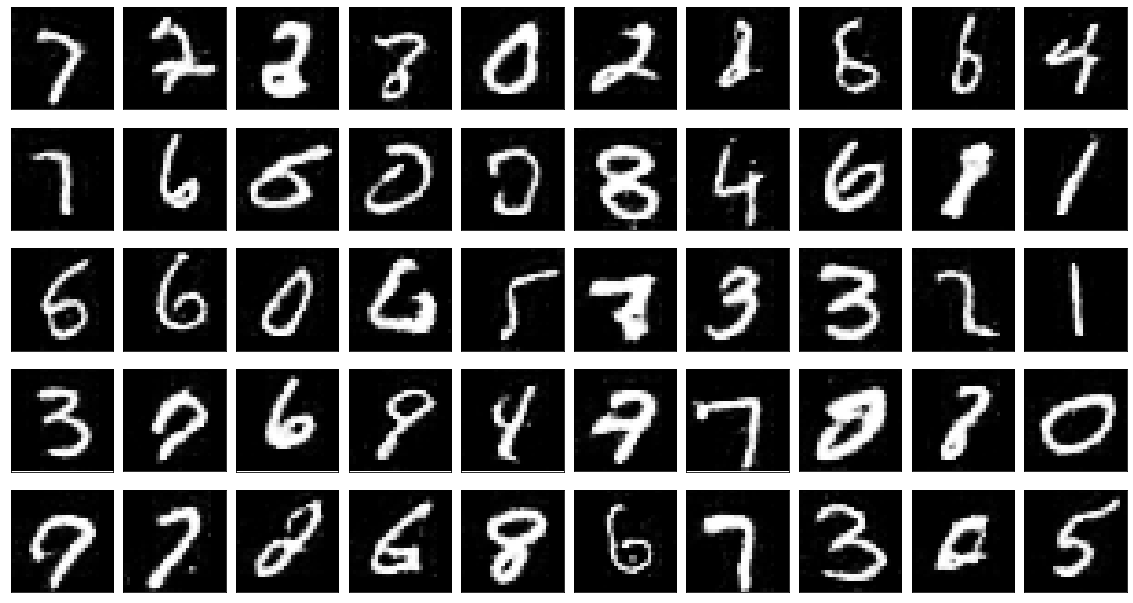

In [22]:
# fake_image作成
generator.eval
noise = torch.randn(50, n_channel, 1, 1, device=device)
sample_images = generator(noise)

# fake_image可視化
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=-0.8)
for i in range(50):
    ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
    ax.imshow(sample_images[i,].view(28,28).cpu().detach(), "gray")